# Session 3
## Lab 1 - netUnicorn API

In this tutorial, we will learn how to use basic netUnicorn API to express Tasks, Pipelines, and Experiments, work with available infrastructure, and explore the results of experiment preparation and execution.

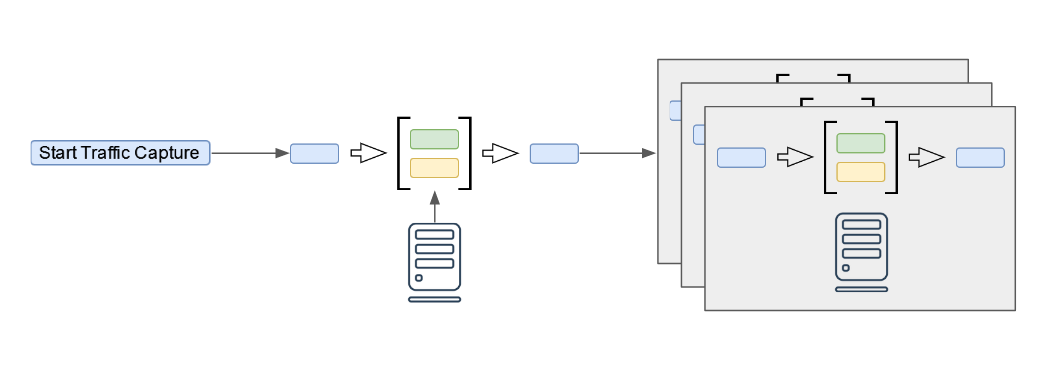

As a reminder from Session 2, the basic API of netunicorn consists of the following things:
1. Task - minimal and basic building blocks of netUnicorn
2. Pipeline - ordered collection of Tasks
3. Node - infrastructure abstraction
4. Deployment - mapping of a pipeline to a node
5. Experiment - set of Deployments

## Task

Tasks allow users to modularly express their intents for experiments. For example, "run the speedtest" is a Task. Tasks could be simple (start tcpdump) or very complex (watch YouTube for X seconds), users define what level of modularity the Task should implement.

Tasks would be later combined into Pipelines (for example, start tcpdump -> watch YouTube -> stop tcpdump).

Tasks consist of three parts:
- Requirements: bash commands that would be executed during compilation of a Docker image for this task. Most often used to install required programs or dependencies.
- `__init__` method: client-side initialization of the task. Allows users to pass some information to be used later (for example, URL of YouTube video to watch)
- `run` method: executor-side code that would be executed on a corresponding node. Implements actual task intent and can use information provided on the initialization step.

You can find an extensive tutorial on Tasks in [github/netunicorn/netunicorn/examples/tasks_and_dispatchers](https://github.com/netunicorn/netunicorn/blob/main/examples/tasks_and_dispatchers.ipynb)

In [ ]:
# This is the simplest and minimal example of Task implementation
from netunicorn.base import Task

class MyFirstTask(Task):
    def run(self):
        return True

In [ ]:
# You can call the task().run() to execute it locally
MyFirstTask().run()

In [ ]:
# This is a more complex task implementation that uses the initialization
class MySecondTask(Task):
    def __init__(self, word: str, *args, **kwargs):
        self.word = word
        super().__init__(*args, **kwargs)  # this is important, don't forget it
    
    def run(self):
        return f"I know the next word: {self.word}"

MySecondTask("SIGCOMM").run()

In [ ]:
# This is a task that has requirements and actually does useful things
class MyThirdTask(Task):
    requirements = ["apt install -y curl"]

    def __init__(self, url: str, *args, **kwargs):
        self.url = url
        super().__init__(*args, **kwargs)

    def run(self):
        import subprocess
        return subprocess.run(["curl", self.url], capture_output=True)

MyThirdTask("https://google.com").run()

In [ ]:
# Finish the Task: the task should accept N (int) seconds during the initialization, sleep for N seconds during the execution and return True

class SleepTask(Task):
    def __init__(self, N: int, *args, **kwargs):
        ### YOUR IMPLEMENTATION STARTS HERE

        ### YOUR IMPLEMENTATION ENDS HERE
        super().__init__(*args, **kwargs)

    def run(self):
        import time
        ### YOUR IMPLEMENTATION STARTS HERE
        # use time.sleep

        ### YOUR IMPLEMENTATION ENDS HERE
        return True

SleepTask(3).run()

## Pipeline

A Pipeline is the main block of the data collection. It's an ordered collection of tasks, separated into _stages_. Each _stage_ contains one or more tasks, and all tasks on the stage would start in parallel, and the stage would finish when all tasks of the stage would finish. Afterward, the next stage will start.

The Pipeline would be deployed to working nodes (servers, PCs, VMs, anything that can run code) to be executed. After the execution, the results of the pipeline would be returned to a user.

Let's look at the Pipeline examples.

In [ ]:
from netunicorn.base import Pipeline

# Three tasks after each other: 3 stages total
pipeline = (
    Pipeline()
    .then(MyFirstTask())
    .then(MySecondTask("SIGCOMM"))
    .then(MyThirdTask("https://google.com"))
)

print(pipeline)

In [ ]:
# All Tasks in parallel: 1 stage total
pipeline = (
    Pipeline()
    .then([
        MyFirstTask(),
        MySecondTask("SIGCOMM"),
        MyThirdTask("https://google.com")
    ])
)

print(pipeline)

In [ ]:
# Two Tasks in parallel and the third after they are finished: 2 stages in total
pipeline = (
    Pipeline()
    .then([
        MyFirstTask(),
        MySecondTask("SIGCOMM"),
    ])
    .then(MyThirdTask("https://google.com"))
)

print(pipeline)

In [ ]:
# Finish the Pipeline:
# stage 1: MyFirstTask()
# stage 2: MySecondTask("SIGCOMM") and MyThirdTask("https://google.com") in parallel

### YOUR IMPLEMENTATION STARTS HERE

### YOUR IMPLEMENTATION ENDS HERE

Both Pipelines and Tasks are easily serializable and shareable, because they do not hold information about any particular infrastructure.

Repository [netunicorn/netunicorn-library](https://github.com/netunicorn/netunicorn-library) provides implementations of different tasks and pipelines that you can use. This repository is also considered to be "contribution" repository, so anyone can create a Pull Request with their implementations of tasks or pipelines and it would be included into official netunicorn-library releases.

## Client

To deploy our Tasks and Pipelines anywhere, we need to start interacting with some real-world infrastructure (via netUnicorn instance). 

This is achieved via `netunicorn.client` module

Overall infrastructure of netUnicorn looks like this:

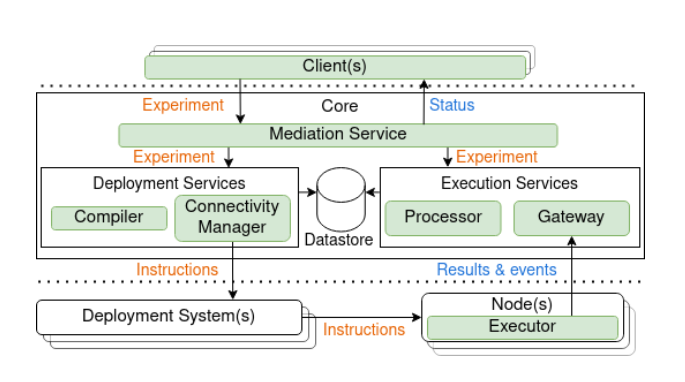

Clients (those who use netunicorn infrastructure and express tasks, pipelines, and experiments) communicate to the netUnicorn director services instance that's located close to real-world infrastructures to use. In this tutorial, we have a single AWS VM infrastructure that we will use for data collection. Director services of netUnicorn are also located on the same machine for simplicity.

To connect to any netUnicorn instance, you need to know endpoint url and a valid login-password combination. As we have instance of netunicorn deployed locally (on port 26611), let's connect there with the `test` user (with password `test`).

In [ ]:
from netunicorn.client import RemoteClient

# we have a netunicorn instance deployed locally, so let's use it
NETUNICORN_ENDPOINT = 'http://localhost:26611'
NETUNICORN_LOGIN = 'test'
NETUNICORN_PASSWORD = 'test'

# create a client and check that connection and instance are ok
client = RemoteClient(endpoint=NETUNICORN_ENDPOINT, login=NETUNICORN_LOGIN, password=NETUNICORN_PASSWORD)
client.healthcheck()

Client provides methods for interaction with infrastructure, experiment lifetime control (prepare, start, cancel, get information), and other things (e.g., flags).

Full list of client's methods could be obtained by reading the documentation: `help(RemoteClient)`.

## Nodes

Infrastructure in netUnicorn is provided by connectors (e.g., to AWS/Azure, Kubernetes cluster, or to some custom physical infrastructure like PINOT). Each connector returns a list of abstract Nodes, each providing some characteristics and descriptions.

Currently, in this tutorial, we have only one connector (Docker connector) that represents a single node - a local machine.

In [ ]:
nodes = client.get_nodes()
print(nodes)

NodePool object (that's returned as the result of `get_nodes`) provides methods `filter`, `skip`, and `take` to manipulate list of nodes. For example:

In [ ]:
nodes.skip(1)  # remember, we have only one node currently

In [ ]:
nodes.filter(lambda node: node.name != "dockerhost")

In [ ]:
nodes.filter(lambda node: node.name.startswith("docker"))

In [ ]:
nodes.take(1)

In [ ]:
# Finish the code:
# Filter all nodes where name equals "dockerhost" and afterwards take one of them
### YOUR IMPLEMENTATION STARTS HERE
...
### YOUR IMPLEMENTATION ENDS HERE

Each node also have properties:

In [ ]:
print(nodes.take(1)[0].properties)    # for more complex nodes there's more properties

In [ ]:
# let's select some nodes
working_nodes = nodes.take(1)

## Experiment

Now we have a Pipeline and nodes to execute this pipeline on.

Experiment is an abstraction that allows you to map Pipelines to Nodes where they should be executed. For example, in our simple scenario we will map a single pipeline to a single node.
In other scenarios, you can (and often will) have different pipelines to map to different nodes, for example one node being a server and several other nodes being clients.

In [ ]:
from netunicorn.base import Experiment

experiment = Experiment().map(pipeline, working_nodes)
print(experiment)

Each object in the experiment is a Deployment - mapping of a particular pipeline to a particular node. They are complex objects and have a lot of parameters that you can explore and change. For example:

In [ ]:
print(experiment[0].environment_definition)

Now we have experiment defined. It's time to start preparing and deploying it.

## Experiment preparation and execution

After experiment is defined, we need to ask netUnicorn instance to prepare the experiment for execution. This is achieved via a client:

In [ ]:
experiment_label = "put-any-word-here"

# you can always delete experiment if such label already exists
# client.delete_experiment(experiment_label)

# and we can send the experiment for preparation
client.prepare_experiment(experiment, experiment_label)

To obtain information about the experiment, you can use the next method:

In [ ]:
client.get_experiment_status(experiment_label)

If experiment is still preparing, you will see it in the status.

If experiment is prepared, each Deployment contains information on what node the pipeline is deployed and whether preparation was successful.

Now we can start execution of our experiment:

In [ ]:
client.start_execution(experiment_label)

In [ ]:
# again, let's check experiment status and wait until it's finished
client.get_experiment_status(experiment_label)

Result of the execution presents the next things:
- Deployment information
- Deployment execution result
- Raw logs from all tasks and the executor itself

The most interesting part here, ofcourse, is execution result. It has result for each Deployment, such as:
- high-level `result` object that is Success if all tasks are successful, and Failure if any of tasks returned Failure or raised an Exception
- result of execution of each task, with the task name (usually some random UUIDv4 if not explicitly set, and yes, you can set explicitly with parameter `name` during initialization) and execution result - Success/Failure and content

## Conclusion

This tutorial showed the basics of the netUnicorn API, so you would be able to work through the next lab. Meanwhile, there's more to learn. Please, take a look at [netunicorn/examples](https://github.com/netunicorn/netunicorn/tree/main/examples) to find additional materials and tutorials.